## BBM409 Introduction to Machine Learning Lab.  Fall 2022.
# Assignment 4

## Implementation of Neural Networks
### Part 2 | Transfer Learning - VGG19

### Contributors:

### Ali Argun Sayilgan   : 21827775
### Mehmet Giray Nacakci :  21989009

## Table of Content

* [Transfer Learning](#transferlearning)     
* [VGG19 Model and Its Architecture](#vgg19)  
---- [Batch Normalization](#batchnormalization)    
* [Visualizing Convolutional Layers](#visualizinglayers)      
* [Loading Data](#loadingdata)     
* [Preproccesing](#Preproccesing)         
---- [Image Compression](#compression)     
* [Mini-batch gradient descent](#minibatch)       
* [Finetuning the entire VGG19](#finetuneentire)    
* [Training all layers of the VGG19](#trainerfunc)     
---- [Early Stopping](#earlystop)       
---- [Optimizer](#optimizer)     
* [Testing fully finetuned VGG19](#testfullyft)     
* [Confusion Matrix](#confmatrix)     
---- [Saving Trained Model(Serialization)](#savingmodelfully)     
* [Training only last 2 FCs of VGG19](#ftpartial)     
* [Testing partially finetuned VGG19](#testpartiallyft)    
* [Fully finetuned vs Partially finetuned Test Accuracy Comparison](#testacccomparison)        
---- [Loading Finetuned VGG19 Models From Disk](#loadstatedict)             
* [Showing few misclassifications](#wrongprediction)     
* [Training time comparison](#trainingtime)     
* [Conclusion](#conclusion)    


# Transfer Learning <a class="anchor" id="transferlearning"></a>

Transfer learning is a machine learning technique where a model trained on a task is re-purposed on a second, related task. This is done by taking the pre-trained weights of the model and using them as initialization for the weights of a new model. The new model is then fine-tuned on the second task by continuing the training process on this new dataset.

Transfer learning is useful because it allows the model to make use of the features and knowledge learned on the first task, which can be used as a strong starting point for the second task. This can significantly reduce the amount of data and computational resources needed to train the model on the second task, as the model has already learned many relevant features from the first task. Additionally, transfer learning can also improve the generalization performance of the model on the second task, as the model has already been exposed to a diverse range of data during training on the first task.



# VGG19 <a class="anchor" id="vgg19"></a>

The VGG19 CNN model is a deep convolutional neural network model developed by the Visual Geometry Group at the University of Oxford. It was introduced in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition" in 2014. The model is trained on the ImageNet dataset, a large dataset of over one million images belonging to 1000 classes.[[1]](https://arxiv.org/abs/1409.1556v6)

One of the main advantages of the VGG19 model is its simplicity. It consists of a series of convolutional and pooling layers, with the number of filters in each convolutional layer increasing as the model progresses. This simple architecture makes the model easy to understand and implement, while still achieving state-of-the-art results on a variety of image recognition tasks.

The VGG19 model is also known for its strong performance on image classification tasks. Its deep architecture allows it to learn rich feature representations from the input images, which enables it to classify images into various categories with high accuracy. Additionally, the model has a relatively small number of parameters, which helps to reduce overfitting and improve the generalization performance of the model.

In [ ]:
from torchvision.models import vgg19
import torch.nn as nn
import torch
from torch.autograd import Variable
import numpy as np
from PIL import Image
from torchvision import datasets, models, transforms


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(24)
num_classes = 15
model_vgg19 = vgg19(pretrained=True)
print(model_vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Batch normalization  <a class="anchor" id="batchnormalization"></a>

In this experiment we will be using the pretrained VGG-19 model on ImageNet, and finetune it for our dataset. There are 2 variations of this model in torchvision library: <b>vgg19</b> and <b>vgg19_bn(Batch normalization)</b>.

In a regular neural network, each layer's input is getting converted to its' output with the following equations

<img src="./assets/NN_functions.svg" width="400px">

In a neural network that makes use of <b>batch normalization</b>, following functions are applied to the inputs respectively.


<img src="./assets/nn_batch_norm.svg" width="600px">

* z^N is the output of Batch Norm<br/>
* m_z the mean of the neurons’ output<br/>
* s_z the standard deviation of the output of the neurons<br/>
* \gamma and \beta are the learning parameters of Batch Norm.<br/>


The reason behind batch normalization is training deep neural networks with numerous layers can be problematic due to the sensitivity of the initial random weights and configuration of the learning algorithm.One potential explanation for this difficulty is the alteration of the input distribution to layers deep in the network following each mini-batch during weight updates, which can lead to the learning algorithm continually attempting to adapt to a moving target. This alteration of input distribution to layers within the network is referred to as "internal covariate shift". Batch normalization is a method used to train very deep neural networks by standardizing the inputs to a layer for each mini-batch, which helps to stabilize the learning process and significantly reduces the number of training epochs required to train deep networks.

In this experiment we will be using regular VGG-19 for simplicity.

<img src="./assets/CNN_Architecture.jpg" width="700px" />


* A fixed size of (224 * 224) RGB image was given as input to this network which means that the matrix was of shape (224,224,3).
* The only preprocessing that was done is that they subtracted the mean RGB value from each pixel, computed over the whole training set.
* Used kernels of (3 * 3) size with a stride size of 1 pixel, this enabled them to cover the whole notion of the image.

Note that we are using Softmax activation function in the end of the model. Later we will be using negative log likelihood as loss function for our CNN. There are a few reasons why the negative log likelihood loss is a good fit for use with the softmax activation function:

1- The softmax activation function is designed to output a probability distribution over the possible class labels, and the negative log likelihood loss is well-suited for training models to predict probability distributions.

2- The negative log likelihood loss is easy to compute and has a nice mathematical interpretation. It is the negative log probability of the true label, given the predicted probability distribution, and it can be interpreted as the "surprisal" of the true label (how surprised we are by the true label, given the predicted probability distribution).

3- The negative log likelihood loss is a smooth, continuous function with a unique global minimum, which makes it easier to optimize during training.

4 -The negative log likelihood loss has nice theoretical properties, such as being consistent with the maximum likelihood principle, which states that the best model is the one that maximizes the likelihood of the observed data.

<img src="./assets/nll und softmax.jpg" width="400px"> <img src="./assets/nll range.png" width="400px"> <br />
The negative log-likelihood becomes unhappy at smaller values, where it can reach infinite unhappiness (that’s too sad), and becomes less unhappy at larger values. Because we are summing the loss function to all the correct classes, what’s actually happening is that whenever the network assigns high confidence at the correct class, the unhappiness is low, but when the network assigns low confidence at the correct class, the unhappiness is high.

In [ ]:
! pip install torchinfo
from torchinfo import summary

In [ ]:
summary(model=model_vgg19, 
        input_size=(1, 3, 224, 224),
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                  [1, 3, 224, 224]     [1, 512, 7, 7]       --                   True
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 224, 224]    1,792                True
│    └─ReLU (1)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─Conv2d (2)                        [1, 64, 224, 224]    [1, 64, 224, 224]    36,928               True
│    └─ReLU (3)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─MaxPool2d (4)                     [1, 64, 224, 224]    [1, 64, 112, 112]    --                   --
│    └─Conv2d (5)                        [1, 64, 112, 112]    [1, 128, 112, 112]   73,856               True
│    └─ReLU (6)     

In [ ]:
conv_layers = []

feature_layers = list(model_vgg19.features.children())

for layer in feature_layers:
    if type(layer) == nn.Conv2d:
        conv_layers.append(layer)

print(f"Total convolution layers: {len(conv_layers)}")

Total convolution layers: 16


In [ ]:
image_dir = './compressed/train/Cucumber/0402.jpg'

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

image = Image.open(image_dir)

model_vgg19 = model_vgg19.to(device)

image = transform(image)
image = image.unsqueeze(0)
image = image.to(device)

#### now let's propogate the image through VGG-19 pretrained model's convolutional layers

In [ ]:
outputs = []
names = []
i = 0
for layer in feature_layers:
    image = layer(image)
    if type(layer) == nn.Conv2d:
        i+=1
        outputs.append(image)
        names.append(str(layer).split('(')[0] + " - " + str(i))

In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

# Visualizing Convolutional Layers <a class="anchor" id="visualizinglayers"></a>
The weights are useful to visualize the CNN layers because well-trained networks usually display nice and smooth filters without any noisy patterns. Noisy patterns can be an indicator of a network that hasn’t been trained for long enough, or possibly a very low regularization strength that may have led to overfitting.

When we optimize the input image in relation to the output of the particular convolution operation, CNN filters can be seen. We employed a this method on pre-trained VGG-19 CNN model. Layer visualizations begin at lower levels with fundamental color and direction filters. The complexity of the filters likewise rises as we get closer to the last layer.

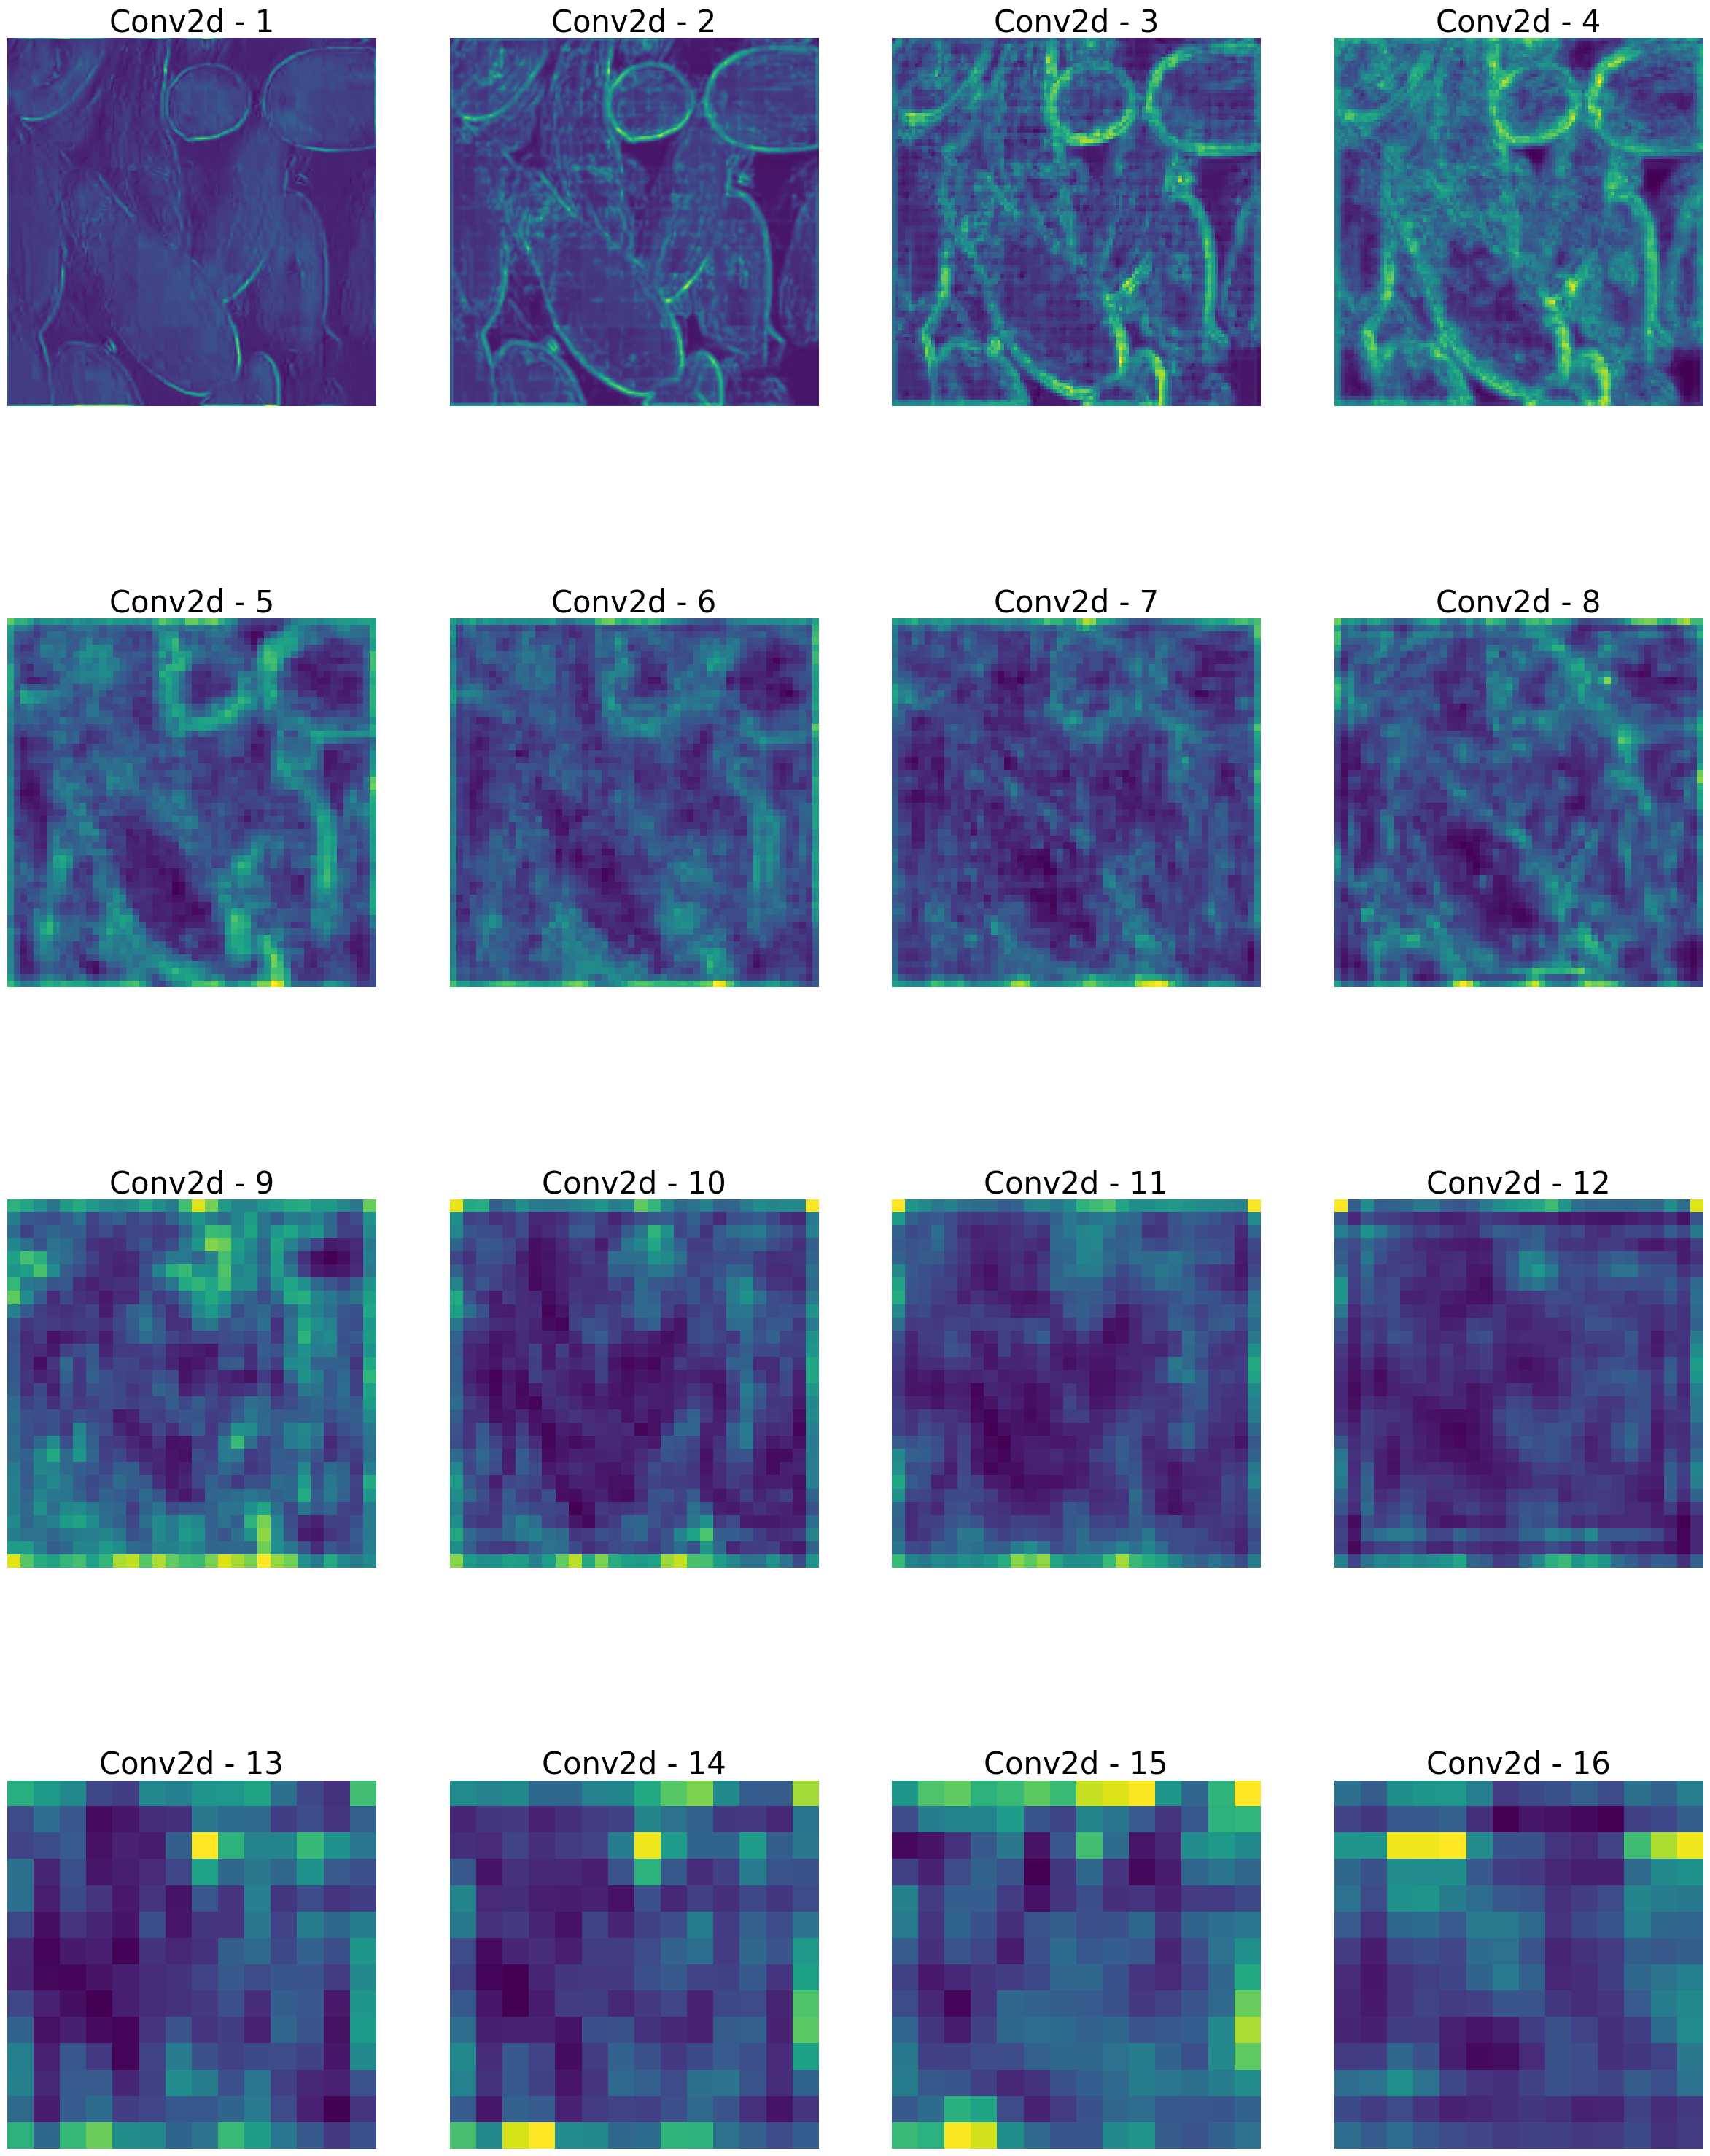

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

As can be seen from the figures, as we propogate through the convolutional layers the images are getting less smooth and are optimized to infer more high-level features from the images.

<img src="./assets/hilocarfilter.png" width="550px"/>

## This experiment consists of two sections:
#### - Finetuning the entire CNN
#### - Finetuning the last Fully Connected Layers of the CNN

# Loading Data  <a class="anchor" id="loadingdata"></a>

We will be using torchvision and torch.utils.data packages for loading the data.

The dataset consists of 15 different vegetables which are: <i>bean, bitter gourd, bottle gourd, brinjal, broccoli, cabbage, capsicum, carrot, cauliflower, cucumber, papaya, potato, pumpkin, radish and tomato</i>. A total of 21000 images from 15 classes are used where each class contains 1400 images of size 224×224 and in *.jpg format. The dataset split 70% for training, 15% for validation, and 15% for testing purpose.The data set was obtained from the following [study](https://www.researchgate.net/publication/352846889_DCNN-Based_Vegetable_Image_Classification_Using_Transfer_Learning_A_Comparative_Study). 





## Preproccesing  <a class="anchor" id="preproccesing"></a>
* Some of the image samples are not 224x224 pixel sized, those images are re-scaled to 224x224 pixel size.

Various preproccessing methods(<i>RandomResizedCrop, RandomFlip, Normalization</i>) could be used to increase model's performance but in this assignment we are not focusing on these subjects.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
! pip install pandas
! pip install matplotlib
import pandas as pd
import torchvision

import matplotlib.pyplot as plt
import time
import os
import copy

from shutil import copyfile

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

### Image Compression  <a class="anchor" id="compression"></a>

As we don't have good enough computation power, we compressed the images like this

In [ ]:
# import PIL
# from PIL import Image
# import os
# path = './dataset'
# export_path = './compressed'
# classes = os.listdir(path)

# for clas in classes:
#     print(clas)
#     images = os.listdir(path + '/' + clas)
#     os.mkdir(export_path + clas)
#     for image in images:
#         image_name = image.rsplit('.',1)[0]
#         image = Image.open(path+ '/' + clas+'/'+image)
#         image.save(export_path + clas + '/' +image_name+'.jpg',optimize=True, quality=18)

Again, when we tried to train our neural networks, an epoch was lasting more than 30 minutes so, we zipped our dataset and trained our neural network with rental GPUs from [vast.ai](https://vast.ai).

In [ ]:
# import zipfile as zf
# files = zf.ZipFile("compressed.zip", 'r')
# files.extractall('./')
# files.close()

## Mini-batch gradient descent | torch.utils.data.DataLoader  <a class="anchor" id="minibatch"></a>

 In each iteration, we update the weights of all the training samples belonging to a particular batch together. This process is repeated with different batches until the whole training data has been processed. Compared to batch gradient descent, the main benefit of this approach is that it can <u>reduce computation time and memory usage significantly</u> as compared to processing all training samples in one shot.
 

When the batch size is set to one, the training algorithm is referred to as stochastic gradient descent. Likewise, when the batch size is greater than one but less than the size of the entire training data, the training algorithm is known as mini-batch gradient descent. By setting batch_size as 32 at DataLoader, we have also set the batch size of the mini-batch stocastic gradient descent.

In [ ]:
data_dir = './'
dataloader_batch_size = 32
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),transform=transform) 
            for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=dataloader_batch_size, shuffle=True, num_workers=1)
            for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

Note that we are shuffling the dataset at the loading stage because of the following 2 reasons:
* We consider shuffling is a way to protect some worst case scenario behaviours.
* As for any stochastic gradient descent method (including the mini-batch case), it is important for efficiency of the estimator that each example or >minibatch be sampled approximately independently. Because random access to memory (or even worse, to disk) is expensive, a good approximation, called incremental gradient (Bertsekas, 2010), is to visit the examples (or mini-batches) in a fixed order corresponding to their order in memory or disk (repeating the examples in the same order on a second epoch, if we are not in the pure online case where each example is visited only once). In this context, it is safer if the examples or mini-batches are first put in a random order (to make sure this is the case, it could be useful to first shuffle the examples). Faster convergence has been observed if the order in which the mini-batches are visited is changed for each epoch, which can be reasonably efficient if the training set holds in computer memory. -- <cite>[Bengio, Yoshua. "Practical recommendations for gradient-based training of deep architectures." Neural Networks: Tricks of the Trade. Springer Berlin Heidelberg, 2012. 437-478.][1]</cite>

[1]: https://arxiv.org/abs/1206.5533

## Finetuning the entire model  <a class="anchor" id="finetuneentire"></a>

Since the pretrained VGG-19 model has 1000 output nodes, we must change it to 15. And it should be noted that, VGG-19 model expects input images to be at 224x224 resolution. And since we are ensuring that input images are 224x224 resolutioned RGB images, we don't need the average pooling layer at VGG-19 model, thus we changed that layer to an identity layer.

In [ ]:
model_vgg19 = vgg19(pretrained=True)
model_vgg19.to(device)
model_vgg19.classifier[6].out_features = 15
# Since we are ensuring the resolutions and color channels of the input images
# to be same, we don't need average pooling
model_vgg19.avgpool = nn.Identity()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Early stopping  <a class="anchor" id="earlystop"></a>
A problem with training neural networks is in the choice of the number of training epochs to use.

Too many epochs can lead model to overfit to the training dataset, whereas too few may result in an underfit model. To resolve this issue we will be using early stopping method. It is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

In [ ]:
class EarlyStopper:
    """
    param patience: indicates the max number of tolarence of model's loss getting increased more than min_delta amount arbitrarily
    param min_delta: if loss is greater than this, it indicates that model's loss increased at last epoch somewhat significantly 
    """
    def __init__(self, patience=2, min_delta=0.05):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=2, min_delta=0.005) 

# Optimizer  <a class="anchor" id="optimizer"></a>

In [ ]:
params_to_update = model_vgg19.parameters()
# Observe that all parameters are being optimized in this section
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

The <b>SGD</b> optimizer in which "stochastic" means a system which is connected or linked up with random probability. In SGD optimizer a few samples is being picked up or we can say a few samples being get selected in a random manner instead taking up the whole dataset for each iteration.

### Choosing optimal learning rate
Generally, a large learning rate allows the model to learn faster, at the cost of arriving on a sub-optimal final set of weights. A smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights but may take significantly longer to train. Before we get into how to choose an optimal learning rate, it should be emphasized that there is no value of the learning rate that will guarantee convergence to the minimum value of the error function (assuming global) value of a function. 

There are several methods that can be choosen for finding an optimal learning rate:

* <u>Learning rate schedule</u>: One simple method is to start with a relatively high learning rate, and then decrease the learning rate over time as the optimization process progresses. This can be done by using a learning rate schedule, which specifies how the learning rate should change at each training iteration.

* <u>Learning rate finder</u>: Another method is to use a learning rate finder, which is an algorithm that helps you find an optimal learning rate by training the model with a range of learning rates and evaluating the model's performance at each one. The learning rate finder can then help you identify the learning rate that gives the best performance.

* <u>Grid search</u>: A grid search is a method of systematically training and evaluating a model using a combination of different hyperparameter values, including the learning rate. This can help you find the combination of hyperparameters that gives the best performance.

* <u>More advanced optimization algorithm</u>: Finally, you can try using a more advanced optimization algorithm that can automatically adjust the learning rate during training. Examples include adaptive gradient algorithms like Adagrad and Adam. These algorithms can often converge on an optimal learning rate more efficiently than methods like grid search or manual learning rate schedules.

Ultimately, the best method for choosing an optimal learning rate will depend on the specific characteristics of the data, dataset size and the model. It should be noted that, even if you reach to an optimal point that might mean your model is overfitted.

In this project, we will be using <u>Learning rate annealing</u> method. It entails starting with a high learning rate and then gradually reducing the learning rate linearly during training. The learning rate can decrease to a value close to 0. The idea behind this method is to quickly descend to a range of acceptable weights, and then do a deeper dive within this acceptable range.


<img src="./assets/sgd_momentum.png" width="400px"/>

<b>Momentum</b>, is an extension to the gradient descent optimization algorithm that allows the search to build inertia in a direction in the search space and overcome the oscillations of noisy gradients and coast across flat spots of the search space.

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Training the model  <a class="anchor" id="trainerfunc"></a>

Mini-batch gradient descent

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, early_stopper):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(8):
        print('Epoch {}'.format(epoch))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:

            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)
                early_stopper.early_stop(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, time_elapsed

In [ ]:
model_vgg19_fully_ft, hist_fully, fully_ft_time = train_model(model_vgg19, dataloaders, criterion, optimizer_ft, early_stopper)

Epoch 0
----------
train Loss: 0.7778 Acc: 0.7884
validation Loss: 0.0623 Acc: 0.9813

Epoch 1
----------
train Loss: 0.0548 Acc: 0.9842
validation Loss: 0.0230 Acc: 0.9923

Epoch 2
----------
train Loss: 0.0203 Acc: 0.9945
validation Loss: 0.0157 Acc: 0.9950

Epoch 3
----------
train Loss: 0.0135 Acc: 0.9961
validation Loss: 0.0187 Acc: 0.9953

Epoch 4
----------
train Loss: 0.0035 Acc: 0.9991
validation Loss: 0.0123 Acc: 0.9977

Epoch 5
----------
train Loss: 0.0040 Acc: 0.9987
validation Loss: 0.0118 Acc: 0.9970

Epoch 6
----------
train Loss: 0.0070 Acc: 0.9981
validation Loss: 0.0143 Acc: 0.9970

Epoch 7
----------
train Loss: 0.0013 Acc: 0.9998
validation Loss: 0.0107 Acc: 0.9990

Training complete in 11m 20s
Best val Acc: 0.999000


# Testing the fully finetuned VGG19  <a class="anchor" id="testfullyft"></a>

In [ ]:
data_dir = './compressed'
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'),transform=transform)        
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)

            
def test_model(model, dataloader):
    confusion_matrix = torch.zeros(15, 15)
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix
fully_ft_conf_matrix = test_model(model_vgg19_fully_ft, dataloader)
fully_ft_conf_matrix = fully_ft_conf_matrix.cpu().detach().numpy()

## Confusion Matrix  <a class="anchor" id="confmatrix"></a>

Confusion matrix is a tabular way of visualizing the performance of your prediction model.


In [8]:
def calculate_metrics(confusion_matrix):
    # Calculate precision, recall and f1 score for each class
    precision = []
    recall = []
    f1 = []
    for i in range(confusion_matrix.shape[0]):
        precision.append(confusion_matrix[i,i]/np.sum(confusion_matrix[:,i]))
        recall.append(confusion_matrix[i,i]/np.sum(confusion_matrix[i,:]))
        f1.append(2 * precision[i] * recall[i] / (precision[i] + recall[i]))
    
    accuracy = np.sum(np.diagonal(confusion_matrix))/np.sum(confusion_matrix)
    
    return precision, recall, f1, accuracy
    
precision_fully_ft, recall_fully_ft, f1_fully_ft, accuracy_fully_ft = calculate_metrics(fully_ft_conf_matrix)

# print(accuracy_fully_ft)

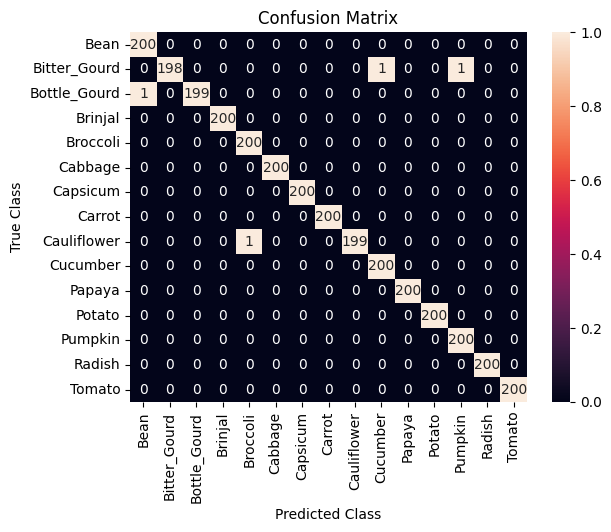

In [ ]:
! pip install seaborn
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, class_names):
    # Get figure and axes
    fig, ax = plt.subplots()
    
    # Create heatmap
    sns.heatmap(confusion_matrix, annot=True, xticklabels=class_names, 
                yticklabels=class_names, ax=ax, fmt='g', vmax=1)
    
    # Add labels and title
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_title('Confusion Matrix')
    
    # Add ticks and rotate labels
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    
    # Show plot
    plt.show()
    
    
plot_confusion_matrix(fully_ft_conf_matrix, class_names)

## Saving the fully trained model's state_dict (Serialization)  <a class="anchor" id="savingmodelfully"></a>

In [ ]:
torch.save(model_vgg19_fully_ft.state_dict(), "./fully_ft_state_dict")

# Finetuning only the last 2 FCs of VGG-19  <a class="anchor" id="ftpartial"></a>

In [ ]:
model_vgg19_partially_ft = vgg19(pretrained=True)
model_vgg19_partially_ft.classifier[6].out_features = 15
model_vgg19_partially_ft.avgpool = nn.Identity()
model_vgg19_partially_ft.classifier

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=15, bias=True)
)

By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is indicating for optimizer functions to calculate gradients over them and optimize those layers. However, in this section of the experiment we are feature extracting and want to optimize only the last two layers of the VGG-19 model. In order the do that, we are changing all layer's  requires_grad attribute to False except last 2 FCs.

In [ ]:
for param in model_vgg19_partially_ft.parameters():
    param.requires_grad = False

for index, param in enumerate(model_vgg19_partially_ft.classifier.parameters()):
    if(index == 0): # We don't want to finetune first FC
        continue
    param.requires_grad = True

In [ ]:
summary(model=model_vgg19_partially_ft, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

As can seen, only the last two layers are trainable.

In [ ]:
optimizer_ft = optim.SGD(model_vgg19_partially_ft.parameters(), lr=0.001, momentum=0.9)

if torch.cuda.is_available():
    model_vgg19_partially_ft.cuda()
    
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [ ]:
early_stopper = EarlyStopper(patience=2, min_delta=0.005) 

model_vgg19_partially_ft, hist_partially, partially_ft_time = train_model(
    model_vgg19_partially_ft, dataloaders, criterion, optimizer_ft, early_stopper)

Epoch 0
----------
train Loss: 0.9003 Acc: 0.7953
validation Loss: 0.1714 Acc: 0.9563

Epoch 1
----------
train Loss: 0.2317 Acc: 0.9311
validation Loss: 0.1177 Acc: 0.9697

Epoch 2
----------
train Loss: 0.1607 Acc: 0.9522
validation Loss: 0.0864 Acc: 0.9767

Epoch 3
----------
train Loss: 0.1248 Acc: 0.9627
validation Loss: 0.0718 Acc: 0.9800

Epoch 4
----------
train Loss: 0.1083 Acc: 0.9671
validation Loss: 0.0582 Acc: 0.9847

Epoch 5
----------
train Loss: 0.0899 Acc: 0.9741
validation Loss: 0.0503 Acc: 0.9883

Epoch 6
----------
train Loss: 0.0791 Acc: 0.9765
validation Loss: 0.0460 Acc: 0.9873

Epoch 7
----------
train Loss: 0.0700 Acc: 0.9800
validation Loss: 0.0436 Acc: 0.9893

Training complete in 4m 24s
Best val Acc: 0.989333


In [ ]:
# saving the partialy finetuned VGG-19 to disk (Serialization)
torch.save(model_vgg19_partially_ft.state_dict(), "./partialy_ft_state_dict")

### Testing partially finetuned VGG19 <a class="anchor" id="testpartialyft"></a>

In [ ]:
data_dir = './compressed'
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'),transform=transform)        
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)

            

partially_ft_conf_matrix = test_model(model_vgg19_partially_ft, dataloader)
partially_ft_conf_matrix  = partially_ft_conf_matrix .cpu().detach().numpy()

In [ ]:
precision_part_ft, recall_part_ft, f1_part_ft, accuracy_part_ft = calculate_metrics(partially_ft_conf_matrix)
print(accuracy_part_ft)

0.99866664


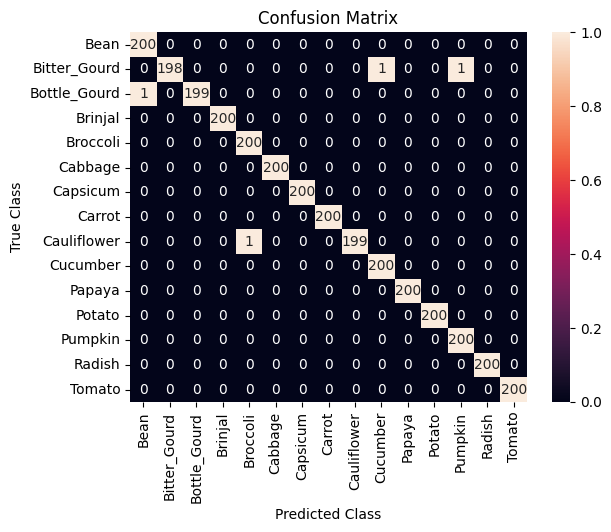

In [ ]:
plot_confusion_matrix(partially_ft_conf_matrix, class_names)

In [ ]:
#### END OF GPU RENTAL, SAVING MY VARIABLES WITH PICKLE. SAD
import pickle

# Serialize variables
with open('variables.pkl', 'wb') as f:
    pickle.dump((hist_fully, fully_ft_time, fully_ft_conf_matrix, precision_fully_ft, 
                 recall_fully_ft, f1_fully_ft, accuracy_fully_ft, hist_partially, partially_ft_time, 
                 partially_ft_conf_matrix, precision_part_ft, recall_part_ft, f1_part_ft, accuracy_part_ft), f)

In [2]:
### START OF LOCAL DEVELOPMENT
! pip install torch
! pip install torchvision
! pip install pandas
! pip install matplotlib
import pickle
import torch
import numpy as np


import pandas as pd
import torchvision

import matplotlib.pyplot as plt
import time
import os
import copy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
with open('variables.pkl', 'rb') as f:
  (hist_fully, fully_ft_time, fully_ft_conf_matrix, precision_fully_ft, 
  recall_fully_ft, f1_fully_ft, accuracy_fully_ft, hist_partially, partially_ft_time, 
  partially_ft_conf_matrix, precision_part_ft, recall_part_ft, f1_part_ft, accuracy_part_ft) = pickle.load(f)


print(hist_fully)

[tensor(0.9813, device='cuda:0', dtype=torch.float64), tensor(0.9923, device='cuda:0', dtype=torch.float64), tensor(0.9950, device='cuda:0', dtype=torch.float64), tensor(0.9953, device='cuda:0', dtype=torch.float64), tensor(0.9977, device='cuda:0', dtype=torch.float64), tensor(0.9970, device='cuda:0', dtype=torch.float64), tensor(0.9970, device='cuda:0', dtype=torch.float64), tensor(0.9990, device='cuda:0', dtype=torch.float64)]


# Recall, f1score, accuracy, precision comparison


In [22]:
import pandas as pd

# initialize data of lists.
data = {
    'accuracy': [accuracy_fully_ft, accuracy_part_ft],
    'precision': [np.mean(precision_fully_ft), np.mean(precision_part_ft)],
    'recall': [np.mean(recall_fully_ft), np.mean(recall_part_ft)],
    'f1_score:': [np.mean(f1_fully_ft), np.mean(f1_part_ft)],
        }
 
# Creates pandas DataFrame.
df = pd.DataFrame(data, index=['fully_ft',
                               'partially_ft'])

df

,accuracy,precision,recall,f1_score:
fully_ft,0.998667,0.998673,0.998667,0.998666
partially_ft,0.980445,0.982952,0.980846,0.981897


### Test Accuracy vs. Number of Training Epochs of fully finetuned VGG19 and partially finetuned VGG19 <a class="anchor" id="testacccomparison"></a>

In [4]:
hist_fully = [h.cpu().numpy() for h in hist_fully]
hist_partially = [h.cpu().numpy() for h in hist_partially]

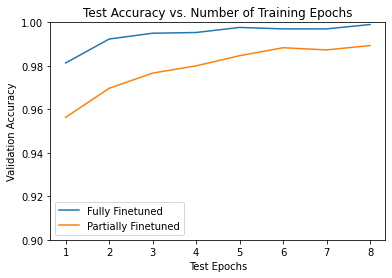

In [ ]:
plt.title("Test Accuracy vs. Number of Training Epochs")
plt.xlabel("Test Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,8+1),hist_fully,label="Fully Finetuned")
plt.plot(range(1,8+1),hist_partially,label="Partially Finetuned")
plt.ylim((0.9,1.))
plt.xticks(np.arange(1, 8+1, 1.0))
plt.legend()
plt.show()

As can be seen from the plot, from first epoch through the 8th epoch there is an upward trend for the accuracies. We have made much more experiments but due to not having GPU in our computers, we can't put those experiments here. We will be mentioning the insights we have gained from those experiments.

# Loading trained VGGs' state_dict from disk (Deserialize) <a class="anchor" id="loadstatedict"></a>

In [ ]:
from torchvision.models import vgg19
import torch.nn as nn

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(24)

#Restructuring fully_ft
model_fully_ft = vgg19(pretrained=True)
model_fully_ft.to(device)
model_fully_ft.classifier[6].out_features = 15
model_fully_ft.avgpool = nn.Identity()

#Restructuring partialy_ft
model_partialy_ft = vgg19(pretrained=True)
model_partialy_ft.to(device)
model_partialy_ft.classifier[6].out_features = 15
model_partialy_ft.avgpool = nn.Identity()

# setting requires_grad parts
for param in model_partialy_ft.parameters():
    param.requires_grad = False

for index, param in enumerate(model_partialy_ft.classifier.parameters()):
    if(index == 0): # We don't want to finetune first FC
        continue
    param.requires_grad = True

In [ ]:
# You can access the state dictionaries from the follow google drive link:
# https://drive.google.com/drive/folders/1LiSZTEzC5cmWxAk36cbIhpjKvCofD73l?usp=sharing
model_fully_ft.load_state_dict(torch.load("fully_ft_state_dict", map_location=torch.device('cpu')))
model_partialy_ft.load_state_dict(torch.load("partialy_ft_state_dict", map_location=torch.device('cpu')))

<All keys matched successfully>

# Visualizing some of the wrong predictions <a class="anchor" id="wrongprediction"></a>


In [ ]:
from torchvision import datasets, models, transforms
data_dir = './'
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'),transform=transform)        
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

def find_incorrectly_predicted_samples(model, dataloader, amount=2):
    confusion_matrix = torch.zeros(15, 15)
    imagesAndPreds = []
    with torch.no_grad():
        for i, (image, label) in enumerate(dataloader):
            if len(imagesAndPreds) == amount:
                return imagesAndPreds
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            _, pred = torch.max(output, 1)
            if(pred != label):
                imagesAndPreds.append((image[0],pred[0], output[0]))
            
    return imagesAndPreds
            

incorrect_predicts_fully = find_incorrectly_predicted_samples(model_fully_ft, dataloader, amount=3)   
incorrect_predicts_partially = find_incorrectly_predicted_samples(model_partialy_ft, dataloader, amount=3)   

Fully finetuned VGG19
Incorrectly labeled images


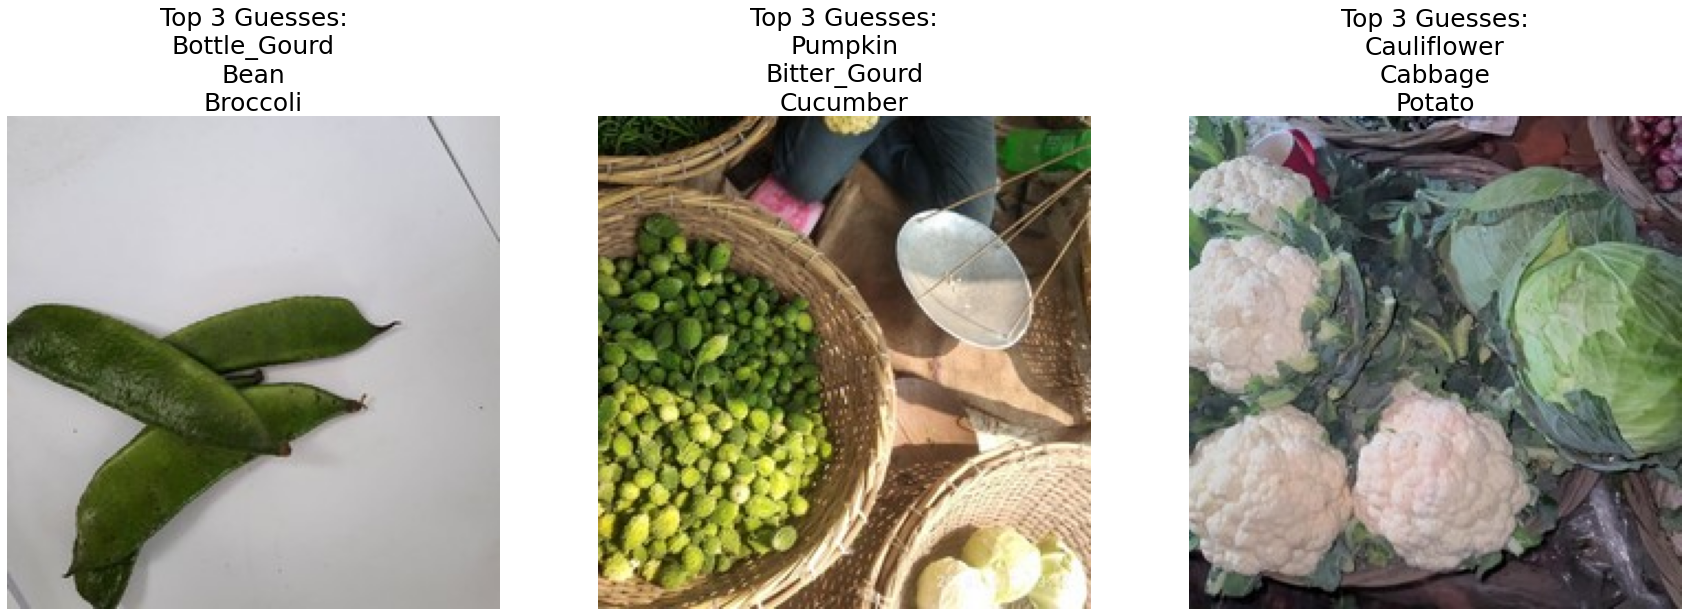

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
# Set up figure and axis
transform = T.ToPILImage()

print("Fully finetuned VGG19")
print("Incorrectly labeled images")
plt.figure(figsize=(30, 10))
for i, (image, text, output) in enumerate(incorrect_predicts_fully):
    plt.subplot(1,3,i+1)
    outputnp = output.cpu().numpy()
    top3indices = outputnp.argsort()[-3:][::-1]
    top3guesses = "Top 3 Guesses:"
    for i in top3indices:
        top3guesses = top3guesses + "\n" + class_names[i]
    plt.title(top3guesses, fontsize = 25)
    plt.axis('off')
    plt.imshow(transform(image))

Partially finetuned VGG19
Incorrectly labeled images


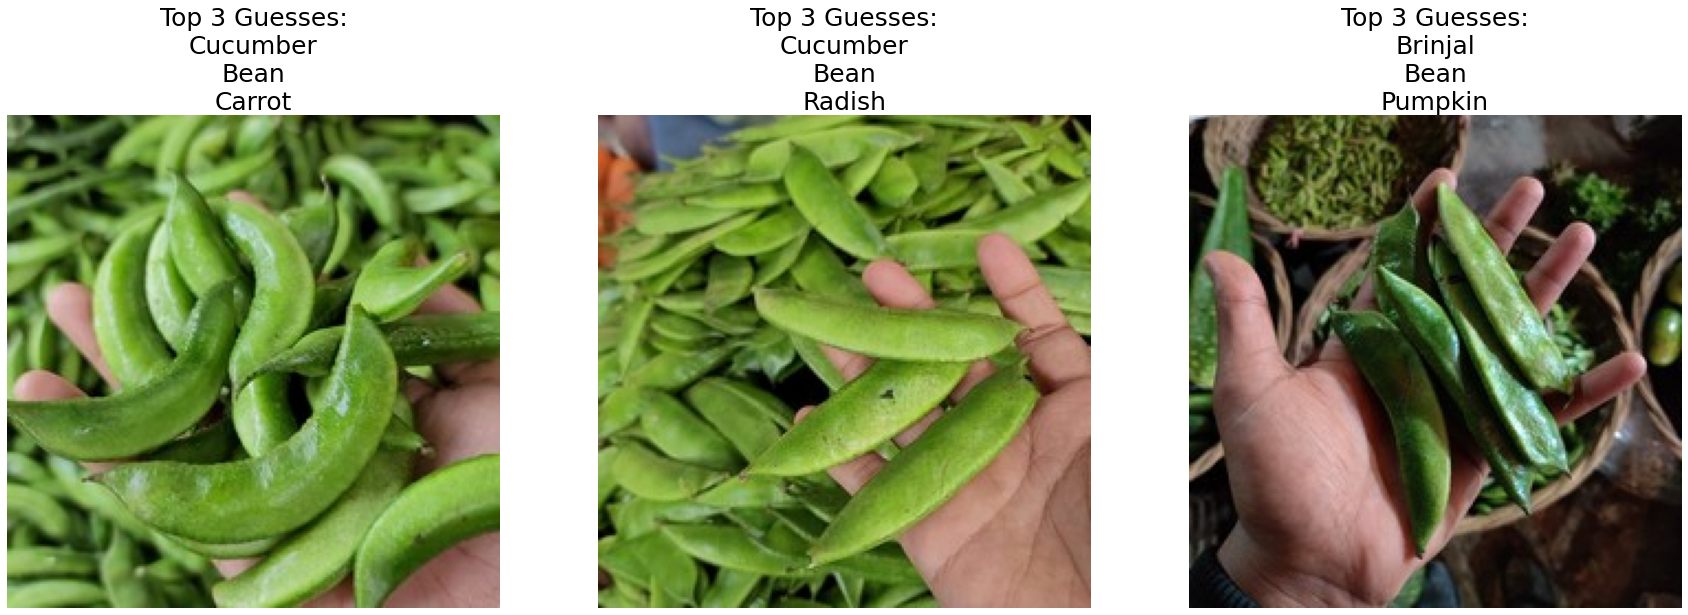

In [ ]:
print("Partially finetuned VGG19")
print("Incorrectly labeled images")
plt.figure(figsize=(30, 10))
for i, (image, text, output) in enumerate(incorrect_predicts_partially):
    plt.subplot(1,3,i+1)
    outputnp = output.cpu().numpy()
    top3indices = outputnp.argsort()[-3:][::-1]
    top3guesses = "Top 3 Guesses:"
    for i in top3indices:
        top3guesses = top3guesses + "\n" + class_names[i]
    plt.title(top3guesses, fontsize = 25)
    plt.axis('off')
    plt.imshow(transform(image))
    

#### Comments on misclassifications

Among all the misclassified examples, the real class label is always among the 3 most likely class labels generated by CNN. And it should be noted that most misclassified images are almost unrecognizable human eye. The trained model performs quite impressively in this regard.

# Training time comparison <a class="anchor" id="trainingtime"></a>


One of the biggest advantages of finetuning only last layers of the VGG19 is that it requires less computational. 









In [1]:
print("Time taken in minutes")
print("To train VGG-19 based on all layers | 8 epochs: {:.2f}".format(fully_ft_time/60))
print("To train VGG-19 based on last 2 FCs | 8 epochs: {:.2f}".format(partially_ft_time/60))

Time taken in minutes
To train VGG-19 based on all layers | 8 epochs: 33.71
To train VGG-19 based on last 2 FCs | 8 epochs: 11.23


# Conclusion <a class="anchor" id="conclusion"><a/>

* In conclusion, fine-tuning only the last fully connected layers of a CNN for transfer learning can be a useful technique in cases where the size of the new dataset is limited and computational resources are scarce. However, it is important to consider the increased potential of overfitting to the dataset. It can be said that, in our experiments we haven't reached to an overfitting situation. Our test accuracy was always have an upward trend, our limitations were the computation.
 
* Training loss with fully fine-tuned VGG-19, we had even reached to accuracy score of 1 after 19 epochs. Though it sounds like an overfit, validation scores and test scores was keep rising. 
    
* The pretrained VGG19 model was very good at extracting features from the input data, and was already well-tuned to recognize patterns and features in images thanks to ImageNet dataset. Even only finetuning the last FCs at first epoch achieves pretty good predictive performance(95.8+-%)

* There is no definitive answer to choosing fully or partially fine-tuning the pre-trained CNN model. It can vary based on your computational power, desired training time, dataset size, training set, and characteristics of classes in the training set.
    
* Consider having a GPU before getting a ML/Computer Vision lectures. It can be realy tough to train your models, serialize and deserialize the state dictionary of the model back and fort. Training and environment setup time took more than 3x time for the development time of this project.

* As seen in the Part 2 of our experiment, CNNs generally performs better at image classification. Also comparing our Part 1 Neural Network with the layering with Part 2: VGG19, Part 1 network only have two hidden layers, whereas VGG19 has many layers. Our Part 1 : Fully Connected Neural Network is not capable of  comprehending complex relationships between pixels and categories of vegetables, as good as our Part 2: VGG network does.

This is the end of our report.